## Modules à importer

In [3]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [4]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNF')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_zcuts['SNF'],
                                                                            x1_zcuts['SDSS'])),
                                                            x1_zcuts['SNLS'])),
                                            x1_zcuts['PS1'])),
                            x1_zcuts['HST']))

datax_err_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_err_zcuts['SNF'],
                                                                                x1_err_zcuts['SDSS'])),
                                                                x1_err_zcuts['SNLS'])),
                                                x1_err_zcuts['PS1'])),
                                x1_err_zcuts['HST']))

dataz_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((z_zcuts['SNF'],
                                                                            z_zcuts['SDSS'])),
                                                            z_zcuts['SNLS'])),
                                            z_zcuts['PS1'])),
                            z_zcuts['HST']))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Défnition _age-law_ depuis _utilisation-evoldouble-surveys_

In [5]:
def age_law(z):
    return 0.995806*stretchevol.MockEvol().delta(z) - 0.609263

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [6]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

n, bins, patches = plt.hist(dataz_all, histedges_equalN(dataz_all, 6))
plt.close()

### Tracé des points

(0.01, 2.65)

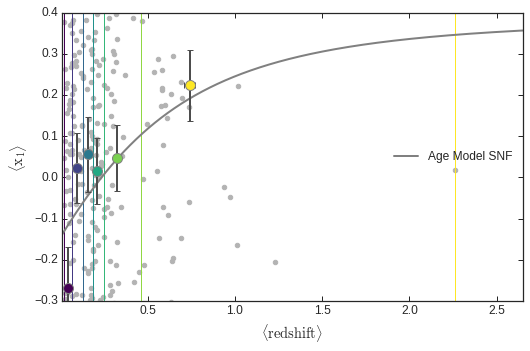

In [9]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

ax.scatter(dataz_all, datax_all, color="0.7")

vmap_v = plt.cm.viridis(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color = vmap_v[i])

slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((dataz_all > bins[i]) & (dataz_all <= bins[i+1])))
    x1_comp_mean[i] = np.mean(datax_all[slices[i]])
    x1_comp_std[i] = np.std(datax_all[slices[i]])
    z_comp_mean[i] = np.mean(dataz_all[slices[i]])
    z_comp_std[i] = np.std(dataz_all[slices[i]])
    
vmap_s = plt.cm.viridis(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               color=vmap_s[i], **prop)

zlin = np.linspace(0, 2.65, 1000)

#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
#ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

ax.plot(zlin, age_law(zlin),
        color="0.5", lw=2, label='Age Model SNF')

#ax.plot(zlin, psi(zlin)-0.3,
#       color="0.5", lw=2, label='$\psi(z)$')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

plt.legend(ncol=1, loc='center right')

#ax.set_ylim(-3, 3)
ax.set_ylim(-0.3, 0.4)
ax.set_xlim(0.01, 2.65)
#ax.set_xscale('log')

## Test de modèle à sigma unique

In [11]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def delta(z):
    '''Gives the fraction of young SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    K = 0.87
    Phi = 2.8
    return (K**(-1)*(1+z)**(-Phi)+1)**(-1)

def likelihood_oS(x, dx, a, mu_1, sigma_1, mu_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return a*gauss(x, dx, mu_1, sigma_1) \
     + (1-a)*gauss(x, dx, mu_2, sigma_1)

def likelihood_yS(x, dx, mu_1, sigma_1):
    '''La fonction décrivant le modèle des SNe jeunes'''
    return gauss(x, dx, mu_1, sigma_1)

def likelihood_totS(z, x, dx, a, mu_1, sigma_1, mu_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return delta(z)*likelihood_yS(x, dx, mu_1, sigma_1) \
     + (1-delta(z))*likelihood_oS(x, dx, a, mu_1, sigma_1, mu_2)

def loglikelihoodS(a, mu_1, sigma_1, mu_2):
    return -2*np.sum(np.log(likelihood_totS(dataz_all, datax_all, datax_err_all,
                                          a, mu_1, sigma_1, mu_2)))

def logpriorS():
    ''' '''
    return 0
                                                                           
def logprobS(a, mu_1, sigma_1, mu_2):
    ''' '''
    loglikelihood_ = loglikelihoodS(a, mu_1, sigma_1, mu_2)
    logprior_ = logpriorS()
    return logprior_ + loglikelihood_


m_totalS = im.Minuit(logprobS, limit_a=(0,1),
                     print_level=0, pedantic=False)

m_totalS.migrad();

/home/nora/installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


## Comparaison avec modèle avec deux sigma

### Fit results for _SNF_

In [12]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

### Recopiage evolD

In [13]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.minimize(a = snf_a,
                    mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                    mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

### Tracé comparatif

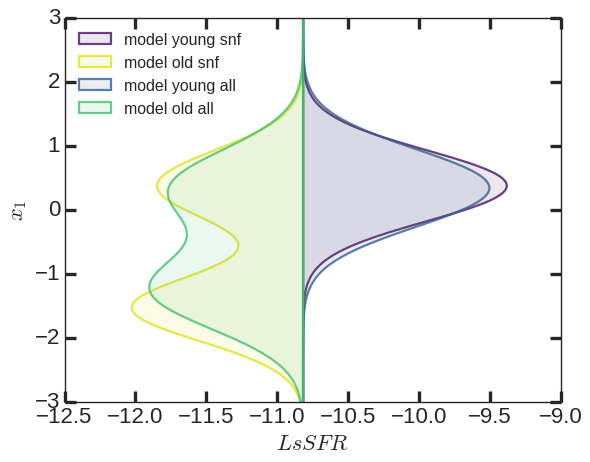

In [16]:
lssfr_med = -10.82

x_linspace = np.linspace(-3, 3, 3000)

plt.fill_betweenx(x_linspace,
                  2*evol3G2M2S.likelihood_y(x_linspace, 0,
                                            snf_mu_1,
                                            snf_sigma_1)
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.05, 0.1),
                  edgecolor=plt.cm.viridis(0.05, 0.8),
                  lw=2, label='model young snf')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*evol3G2M2S.likelihood_o(x_linspace, 0,
                                             snf_a,
                                             snf_mu_1,
                                             snf_sigma_1,
                                             snf_mu_2,
                                             snf_sigma_2)
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.95, 0.1),
                  edgecolor=plt.cm.viridis(0.95, 0.8),
                  lw=2, label='model old snf')

plt.fill_betweenx(x_linspace,
                  2*likelihood_yS(x_linspace, 0,
                                 m_totalS.values['mu_1'],
                                 m_totalS.values['sigma_1'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.30, 0.1),
                  edgecolor=plt.cm.viridis(0.30, 0.8),
                  lw=2, label='model young all')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*likelihood_oS(x_linspace, 0,
                                       m_totalS.values['a'],
                                       m_totalS.values['mu_1'],
                                       m_totalS.values['sigma_1'],
                                       m_totalS.values['mu_2'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.70, 0.1),
                  edgecolor=plt.cm.viridis(0.70, 0.8),
                  lw=2, label='model old all')

ax = plt.gca()
                                     
ax.tick_params(axis='both',
               direction='in',
               length=10, width=3,
               labelsize=20,
               which='both',
               top=True, right=True)

plt.xlabel('$LsSFR$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)

plt.legend(ncol=1, loc='upper left')